# Assignment 4, part 2
## Instructor: Nidhi Hegde

## Instructions
**Reminder.** You must submit your own work.  The collaboration policy for the assignments is Consultation Collaboration. You may verbally discuss concepts with your classmates, without exchanging written text, code, or detailed advice.  You must develop your own solution and submit your own work.  All sources of information used including books, websites, students you talked to, must be cited in the submission.  Please see the course FAQ document for details on this collaboration policy.  We will adhere to current Faculty of Science guidelines on dealing with suspected cases of plagiarism.

You must use this notebook to complete your assignment. You will execute the questions in the notebook. The questions might ask for a short answer in text form or for you to write and execute a piece of code. Make sure you enter your answer in either case only in the cell provided.

Incase any of the packages are not installed on your local system run the following command on your command line and make sure the `requirements.txt` file is also downloaded.
```bash
pip install -r requirements.txt
```

Your submitted notebook should run on our local installation.  So if you are importing packages not listed in the notebook or using local data files not included in the assignment package, make sure the notebook is self-contained with a requirements.txt file or cells in the notebook itself to install the extra packages.  If we cannot run your notebook, you will lose 50% of the marks, and any additional marks that may be lost due to wrong answers.

### Submission Instructions
When you are done, you will submit your work from the notebook. Make sure to save your notebook before running it, and then submit on eClass the notebook file with your work completed. Name your file with your lastname and the assignment number: Lastname_A4-2.ipynb

# Assignment 4: Fairness analysis of the COMPAS Tool

We will consider the fairness case study we examined in class, the ProPublica [investigation](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) of the Correctional Offender Management Profiling for Alternative Sanctions (COMPAS) tool used in Broward county, Florida, for judicial hearings. COMPAS generates a risk assessment for defendants in a criminal trial, which is then used by judges to decide on bail, jail, sentencing, etc.  As with the ProPublica analysis, we will fcus on the recidivism score.  This score is claimed to give a likelihood of an individual recidivating (committing another crime) within the following two years of the assessment.

In this lab, we will go through parts of ProPublica's analysis of COMPAS, focusing on how the recidivism risk scale varies by race and sex.

This notebook has four stages in which we will:
1. Import the data, implement a few pre-processing steps, and inspect the data
2. Run a short exploratory analysis of the COMPAS recidivism score, our primary variable of interest
3. Reproduce the logistic regression model in ProPublica's analysis and interpret the estimates
4. Compute the predictive accuracy of the risk score labels

In [129]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
path = "/content/drive/MyDrive/2nd /WINTER 2024/CMPUT 200/ASSIGN/4/B/"
filename = "compas_data_two_years (2).csv"
data = pd.read_csv(path + filename)
data

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


In [131]:
# Don't change this cell; just run it.
#!pip install -r requirements.txt
import numpy as np
from numpy.random import default_rng
import pandas as pd
from scipy.optimize import minimize
import statsmodels.api as sm

# These lines do some fancy plotting magic.
import matplotlib
# This is a magic function that renders the figure in the notebook, instead of displaying a dump of the figure object.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [132]:
# Don't change this cell; just run it.
rng_seed = 42
rng = default_rng(rng_seed)
rngstate = np.random.RandomState(rng_seed)

In [133]:
# Downloading the data files from Google Drive
!pip install --upgrade gdown
import gdown
url = "https://drive.google.com/drive/folders/1wQZ8Y6pBGI4UFMb9WZNQa69vM8o7IRmA?usp=drive_link"
gdown.download_folder(url)

Retrieving folder contents


Processing file 1zoUwZCxyT80QPM8UHrXXhJT6TdouES_O compas_data_two_years.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1zoUwZCxyT80QPM8UHrXXhJT6TdouES_O
To: /content/data/compas_data_two_years.csv
100%|██████████| 2.54M/2.54M [00:00<00:00, 21.7MB/s]
Download completed


['/content/data/compas_data_two_years.csv']

# Part 1
This part should have been completed as part of Assignment 4-1.  If you have not done it for the submission of Assignment 4-1, you will need to do it now.  This part is not marked for Assignment 4-2.

## Data
We will first load the data, carry out some cleaning and pre-processing, and inspect the data to understand what exploratory steps we will take.

Note that we will use the dataset provided by publica on their github site.  Rather than download the data locally, we will pull the data directly from the github site.  There are a few datasets on the github repository, but we will use one specific one.  The url for the dataset is [https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv](https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv)

In [134]:
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df_init = pd.read_csv(url)

print("Shape:", df_init.shape)
print(df_init.head(5))


Shape: (7214, 53)
   id                name   first         last compas_screening_date   sex  \
0   1    miguel hernandez  miguel    hernandez            2013-08-14  Male   
1   3         kevon dixon   kevon        dixon            2013-01-27  Male   
2   4            ed philo      ed        philo            2013-04-14  Male   
3   5         marcu brown   marcu        brown            2013-01-13  Male   
4   6  bouthy pierrelouis  bouthy  pierrelouis            2013-03-26  Male   

          dob  age          age_cat              race  ...  v_decile_score  \
0  1947-04-18   69  Greater than 45             Other  ...               1   
1  1982-01-22   34          25 - 45  African-American  ...               1   
2  1991-05-14   24     Less than 25  African-American  ...               3   
3  1993-01-21   23     Less than 25  African-American  ...               6   
4  1973-01-22   43          25 - 45             Other  ...               1   

   v_score_text  v_screening_date  in_custod

In class we exmained the data collection methodology of the ProPublica investigation and analysis.  Make sure you have read through their [methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm).  It is crucial, in every data analysis project, to have a good understanding of the data.  This includes:  how the data was collected, what sources the data originate from, how data were merged, what the data columns refer to, etc.  You will note that the ProPublica team combined COMPAS tool data they received from a public records request, with public criminal records from the Broward County Clerk’s Office to create the profiles for the individuals in the dataset.  The COMPAS tool output data includes at least three COMPAS scores: "Risk of Recidivism," "Risk of Violence" and "Risk of Failure to Appear". COMPAS scores for each defendant ranged from 1 to 10, with 10 being the highest risk. Scores from 1 to 4 were labeled by the tool as "Low," 5 to 7 were labeled “Medium," and 8 to 10 were labeled “High.”

### Data pre-processing
We will follow ProPublica's methodology in pre-processing the data.  Note that the data we imported was already filtered so that only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility were included.  In their pre-processing, they first retain only relevant columns, for ease of analysis and inspection.  Then they remove several rows due to missing data.  Form their analysis (paraphrased and commented):
- If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, we do not have the right offense. (keep rows `days_b_screening_arrest <= 30` and `days_b_screening_arrest >= -30` )
- We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all. ( keep rows where `is_recid` is not -1)
- In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them). (keep rows where `c_charge_degree` is not "O" - note this is the letter O)


We also want to filter out any "N/A" in the `score_text` - note that this column contains strings.

In [135]:
cols_retain = ["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"]
df = df_init[cols_retain].copy()

# Filter out rows based on specified criteria
df = df[(df["days_b_screening_arrest"] <= 30) & (df["days_b_screening_arrest"] >= -30)]
df = df[df["is_recid"] != -1]
df = df[df["c_charge_degree"] != "O"]
df = df[df["score_text"] != "N/A"]

print("Shape: ", df.shape)
df.head(5)



Shape:  (6172, 13)


,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30


We will be working with decile_score, which represents the score that the COMPAS tool generates for the individuals.  Let's first be certain the values are numeric.  You would use `pd.to_numeric`.  Note that there might be NaN values, and if so, you should drop those rows.

In [136]:
df['decile_score'] = pd.to_numeric(df['decile_score'], errors='coerce')
df = df.dropna(subset=['decile_score'])

df.shape

(6172, 13)

### Data exploration
Let us now explore the statistics of the data.  The compas data includes the `decile_score` which is the score calculated by the COMPAS tool.  Our goal is to compare the analysis of this score, with the outputs of a logistic regression model we will build ourselves.

We will  plot the distribution of the score, according to race to see how they differ.


Let's first create dataframes that are specific to the two races.  In the cell below, create the new dataframes `df_black` and `df_white` so that `df_black` holds all the rows that correspond to the race being "African-American" and `df_white` holds all the rows that correspond to the race being "Caucaisian".

In [137]:
df_black = df[df['race'] == 'African-American']
df_white = df[df['race'] == 'Caucasian']


Now we will plot histograms for these two dataframes.  The histogram will have the Decile Score on the x axis, 10 bins corresponding to the 10 values and the y axis will be the _proportion_ of individuals of each race that have that decile score.  So the y values for each race will be the number of individuals having a given score divided by the total number of individuals of that race.

You can choose how you want to represent the histograms: two separate sub plots side by side, or both on one plot with different colours each, etc.  The axis limits should be same on both plots (same scale) and the plots should have appropriate titles, axis labels, and if needed a legend.

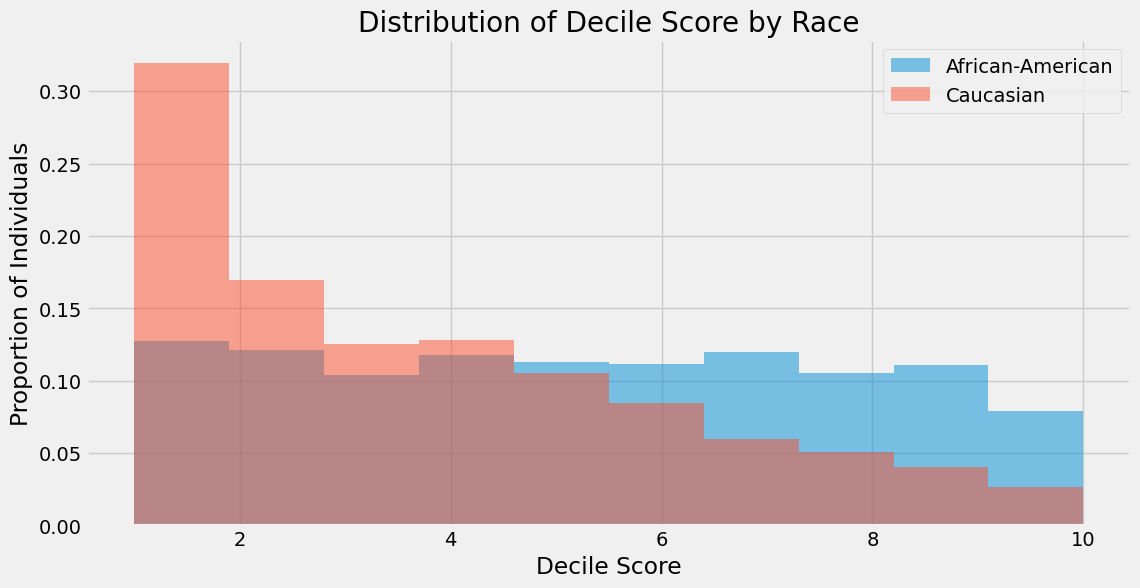

In [138]:
# Calculate the total number of individuals for each race
total_black = len(df_black)
total_white = len(df_white)

# Plot histograms
plt.figure(figsize=(12, 6))

# Histogram for African-American race
plt.hist(df_black['decile_score'], bins=10, alpha=0.5, label='African-American', density=True)

# Histogram for Caucasian race
plt.hist(df_white['decile_score'], bins=10, alpha=0.5, label='Caucasian', density=True)

plt.xlabel('Decile Score')
plt.ylabel('Proportion of Individuals')
plt.title('Distribution of Decile Score by Race')
plt.legend()

plt.show()


#### Question 1
Describe the two plots, especially any differences you see between them.  What does this tell you about the distribution of the decile scores with respect to the senstive feature race?




The two histograms show the distribution of decile scores for African-American and Caucasian individuals.

In the plot for African-Americans, we see a higher proportion of individuals with decile scores in the higher range (e.g., 5-10) compared to the plot for Caucasians.The plot for African-American shows a more evenly distributed pattern across the decile scores. This suggests that African-American individuals are more likely to receive higher scores from the COMPAS tool, indicating a higher perceived risk of recidivism.

On the other hand, the plot for Caucasians shows a right-skewed distributed pattern, with a high peak at the low decile scores range(e.g., 0-1). More Caucasian than African-American receive score from the range 0-4. This indicates that Caucasians are less likely to receive mediem to high scores from the COMPAS tool.

Overall, these differences suggest that there may be disparities in the distribution of decile scores based on race, which raises concerns about fairness and bias in the COMPAS tool with respect to the sensitive feature of race.

#### Question 2
We will now consider gender.  Follow the same steps as above, now for the gender feature.

Create dataframes that are specific to the two races.  In the cell below, create the new dataframes `df_male` and `df_female` so that `df_male` holds all the rows that correspond to the sex being "Male" and `df_female` holds all the rows that correspond to the sex being "Female".

In [139]:
df_male = df[df['sex'] == 'Male']
df_female = df[df['sex'] == 'Female']


Now we will plot histograms for these two dataframes.  The histogram will have the Decile Score on the x axis, 10 bins corresponding to the 10 values and the y axis will be the _proportion_ of individuals of each sex that have that decile score.  So the y values for each sex will be the number of individuals having a given score divided by the total number of individuals of that sex.

You can choose how you want to represent the histograms: two separate sub plots side by side, or both on one plot with different colours each, etc.  The axis limits should be same on both plots (same scale) and the plots should have appropriate titles, axis labels, and if needed a legend.

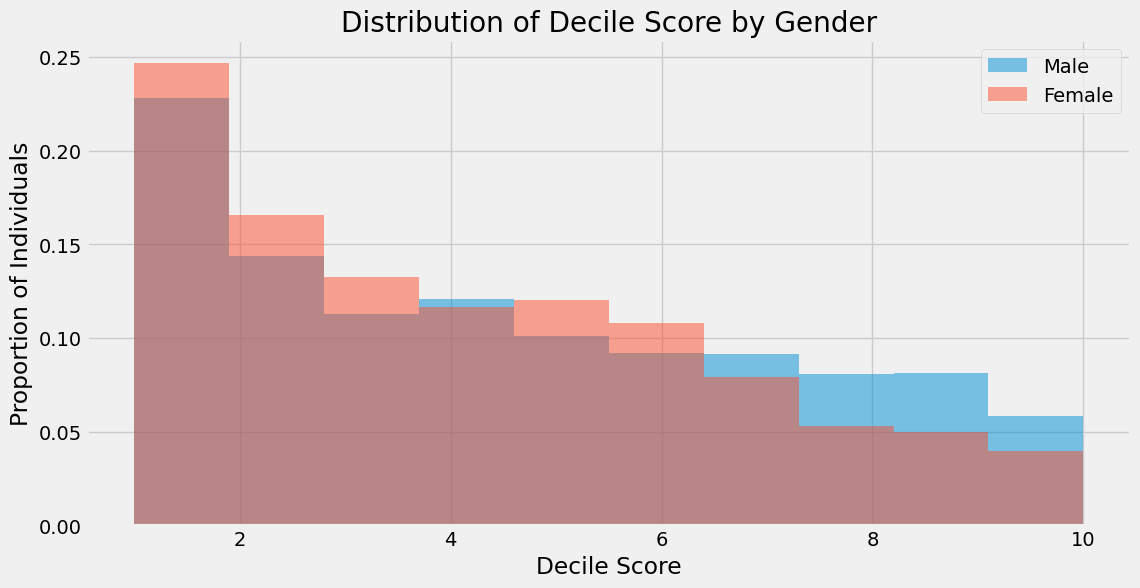

In [140]:
# Calculate the total number of individuals for each gender
total_male = len(df_male)
total_female = len(df_female)

# Plot histograms
plt.figure(figsize=(12, 6))

# Histogram for Male gender
plt.hist(df_male['decile_score'], bins=10, alpha=0.5, label='Male', density=True)

# Histogram for Female gender
plt.hist(df_female['decile_score'], bins=10, alpha=0.5, label='Female', density=True)

# Set axis labels and title
plt.xlabel('Decile Score')
plt.ylabel('Proportion of Individuals')
plt.title('Distribution of Decile Score by Gender')
plt.legend()

# Show plot
plt.show()


#### Question 3
Describe the two plots, especially any differences you see between them.  What does this tell you about the distribution of the decile scores with respect to the senstive feature sex?

The two histograms show the distribution of decile scores for male and female individuals.

Both histograms exhibit a right-skewed distribution, indicating that the majority of individuals receive low to medium decile scores from the COMPAS tool.

However, the plot for females is less steep and somewhat more evenly distributed across the decile scores compared to the plot for males specifically in the score range 5-10. This suggests that females are more likely to receive higher scores from the COMPAS tool, indicating a more perceived risk of recidivism compared to males.

Overall, these differences suggest that there may be disparities in the distribution of decile scores based on gender, with females showing a less extreme distribution compared to males.

# Part 2
This part is marked for Assignment 4-2

## Fairness / Bias in COMPAS

Now we will develop our own logistic regression model to predict a risk value given the data and see how it does with respect to fairness metrics.

#### Pre-processing
We first have some preprocessing to do.

Logistic regression is used here as a classification algorithm, so will give binary outputs.  The COMPAS data contains a `score_text` column, which has values `low`, `medium`, `high`.  This category is used by the judicial decision makers, where a risk of `low` means the person has low likelihood of recidivism and a risk of `medium` or `high` means the person has high likelihood of recidivism.  We will compare our model's output with this score that is the output from COMPAS.  Our model's output of 0 will correspond to `low` in the `score-text` column, and an output of 1 will correspond to `medium` or `high` in the `score-text` column.

The label for our model will be the true label of whether an individual recidivated or not, which is shown in the feature `two_year_recid`.  A value of 0 indicates the individual did not recidivate and 1 indicates they did.

We will use `sklearn`'s logistic regression model which takes numerical input.  So we will have to convert the categorical features to numerical features.  We will use one-hot encoding for this.


Let's first set up a dataframe for the label, or target values.  This will be the column `two-year_recid`.  In the cell below extract that column into a separate dataframe, our target dataframe.

In [141]:
data

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


In [142]:
Y = df[['two_year_recid']]
Y

,two_year_recid
0,0
1,1
2,1
5,0
6,1
...,...
7209,0
7210,0
7211,0
7212,0


Now let's set up the remaining data - we will first drop the target column

In [143]:
# just run this cell
X=df.drop(columns="two_year_recid")
X

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,c_jail_in,c_jail_out
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,2013-04-13 04:58:34,2013-04-14 07:02:04
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,2013-11-30 04:50:18,2013-12-01 12:28:56
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,2014-02-18 05:08:24,2014-02-24 12:18:30
...,...,...,...,...,...,...,...,...,...,...,...,...
7209,23,F,African-American,Less than 25,Medium,Male,0,-1.0,7,0,2013-11-22 05:18:27,2013-11-24 02:59:20
7210,23,F,African-American,Less than 25,Low,Male,0,-1.0,3,0,2014-01-31 07:13:54,2014-02-02 04:03:52
7211,57,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,2014-01-13 05:48:01,2014-01-14 07:49:46
7212,33,M,African-American,25 - 45,Low,Female,3,-1.0,2,0,2014-03-08 08:06:02,2014-03-09 12:18:04


The ProPublica analysis further used only certain features.  We will use the same.  These are: `priors_count`, `c_charge_degree`, `age_cat`, `race`, `sex`.  In the next cell, retain only these columns in our features dataframe `X`.

In [144]:
cols_retain = ['priors_count', 'c_charge_degree', 'age_cat', 'race', 'sex']
X = df[cols_retain].copy()
X

,priors_count,c_charge_degree,age_cat,race,sex
0,0,F,Greater than 45,Other,Male
1,0,F,25 - 45,African-American,Male
2,4,F,Less than 25,African-American,Male
5,0,M,25 - 45,Other,Male
6,14,F,25 - 45,Caucasian,Male
...,...,...,...,...,...
7209,0,F,Less than 25,African-American,Male
7210,0,F,Less than 25,African-American,Male
7211,0,F,Greater than 45,Other,Male
7212,3,M,25 - 45,African-American,Female


Since we will use `sklearn`'s logistic regression model, we need all our data to be numerical values.  Let's first examine the column types.

Run the following cell to examine the data.

In [145]:
X.dtypes

priors_count        int64
c_charge_degree    object
age_cat            object
race               object
sex                object
dtype: object

A data type of `object` indicates that the column is categorical.  We will need to convert these to numerical.  We will use one hot encoding on the categorical features. We first separate the numerical and categorical featues using `selector`.  Then we transform the categorial features using one hot encoding and we normalize the numerical features using a sclaer.  See for instance here for help on this step: <https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py>

In [146]:
df_cat = X.select_dtypes(object)
df_num = X.select_dtypes(np.number)

In [147]:
df_num

,priors_count
0,0
1,0
2,4
5,0
6,14
...,...
7209,0
7210,0
7211,0
7212,3


In [148]:
df_cat

,c_charge_degree,age_cat,race,sex
0,F,Greater than 45,Other,Male
1,F,25 - 45,African-American,Male
2,F,Less than 25,African-American,Male
5,M,25 - 45,Other,Male
6,F,25 - 45,Caucasian,Male
...,...,...,...,...
7209,F,Less than 25,African-American,Male
7210,F,Less than 25,African-American,Male
7211,F,Greater than 45,Other,Male
7212,M,25 - 45,African-American,Female


In [149]:
import warnings
warnings.filterwarnings('ignore')


## Convert all categorical to numerical in one go using custom function

In [150]:
X_encoded = pd.get_dummies(X, columns=['c_charge_degree', 'age_cat', 'race'])
X_encoded['sex'] = X['sex'].map({'Female': 0, 'Male': 1})
# Perform one-hot encoding with custom mapping for 'race' column
X_encoded['race'] = X['race'].map({'African-American': 0, 'Caucasian': 1})

X_encoded

,priors_count,sex,c_charge_degree_F,c_charge_degree_M,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,race
0,0,1,True,False,False,True,False,False,False,False,False,False,True,NaN
1,0,1,True,False,True,False,False,True,False,False,False,False,False,0.0
2,4,1,True,False,False,False,True,True,False,False,False,False,False,0.0
5,0,1,False,True,True,False,False,False,False,False,False,False,True,NaN
6,14,1,True,False,True,False,False,False,False,True,False,False,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,0,1,True,False,False,False,True,True,False,False,False,False,False,0.0
7210,0,1,True,False,False,False,True,True,False,False,False,False,False,0.0
7211,0,1,True,False,False,True,False,False,False,False,False,False,True,NaN
7212,3,0,False,True,True,False,False,True,False,False,False,False,False,0.0


In [151]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

np.random.seed(0)

In [152]:
from sklearn.datasets import fetch_openml

# Fetch the Titanic dataset
titanic = fetch_openml("titanic", version=1, as_frame=True)

# Extract features and target variable
X1 = titanic.frame.drop('survived', axis=1)
y1 = titanic.frame['survived']


In [153]:
X1

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,None,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3.0,"Zabour, Miss. Hileni",female,14.5000,1.0,0.0,2665,14.4542,None,C,None,328.0,None
1305,3.0,"Zabour, Miss. Thamine",female,NaN,1.0,0.0,2665,14.4542,None,C,None,NaN,None
1306,3.0,"Zakarian, Mr. Mapriededer",male,26.5000,0.0,0.0,2656,7.2250,None,C,None,304.0,None
1307,3.0,"Zakarian, Mr. Ortin",male,27.0000,0.0,0.0,2670,7.2250,None,C,None,NaN,None


This code defines a preprocessor for a machine learning pipeline using scikit-learn. Here's a breakdown of each component:

1. `numeric_features = ["age", "fare"]`: Specifies the names of the numeric features in the dataset.

2. `numeric_transformer`: Defines a pipeline for processing numeric features. It consists of two steps:
   - `SimpleImputer(strategy="median")`: Imputes missing values in numeric features using the median value of each feature.
   - `StandardScaler()`: Scales the numeric features to have a mean of 0 and a standard deviation of 1.

3. `categorical_features = ["embarked", "sex", "pclass"]`: Specifies the names of the categorical features in the dataset.

4. `categorical_transformer`: Defines a pipeline for processing categorical features. It consists of two steps:
   - `OneHotEncoder(handle_unknown="ignore")`: Encodes categorical features as one-hot vectors, with an option to handle unknown categories.
   - `SelectPercentile(chi2, percentile=50)`: Selects the top 50% of features based on the chi-squared statistic, which measures the independence between categorical variables.

5. `preprocessor`: Combines the numeric and categorical transformers into a single `ColumnTransformer` object. It specifies that the `num` transformer should be applied to the `numeric_features` and the `cat` transformer should be applied to the `categorical_features`.

Overall, the `preprocessor` is a flexible and powerful tool for preprocessing mixed-type datasets before feeding them into a machine learning model.

In [154]:
numeric_features = ["age", "fare"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ["embarked", "sex", "pclass"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

This code snippet demonstrates the construction and evaluation of a machine learning pipeline using scikit-learn. Here's a breakdown of each part:

1. `clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())])`: This line creates a pipeline named `clf` that consists of two steps:
   - `"preprocessor"`: The `preprocessor` object created earlier, which preprocesses the data (scaling and encoding).
   - `"classifier"`: An instance of `LogisticRegression()`, which is the classifier that will be trained on the preprocessed data.

2. `X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)`: This line splits the dataset `X` and target `y` into training and testing sets. The `test_size=0.2` argument specifies that 20% of the data should be used for testing, and `random_state=0` ensures reproducibility.

3. `clf.fit(X_train, y_train)`: This line fits the pipeline `clf` to the training data `X_train` and `y_train`, which includes both preprocessing (`preprocessor`) and training the classifier (`LogisticRegression`).

4. `print("model score: %.3f" % clf.score(X_test, y_test))`: This line evaluates the performance of the model on the test set by using the `score` method of the pipeline, which calculates the accuracy of the model. The accuracy is then printed with three decimal places.

Overall, this code demonstrates how to create a pipeline that preprocesses data and trains a classifier, making it easy to apply the same preprocessing steps to new data in a production environment.

In [158]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


In [160]:
# Append classifier to preprocessing pipeline. Now we have a full prediction pipeline.
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=0)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.798


This code snippet demonstrates how to use `ColumnTransformer` from scikit-learn to preprocess a dataset with mixed data types (numerical and categorical). Here's a breakdown of each part:

1. `from sklearn.compose import make_column_selector as selector`: Importing the `make_column_selector` function from scikit-learn's `compose` module. This function allows you to create column selectors based on column data types.

2. `from sklearn.preprocessing import OneHotEncoder, StandardScaler`: Importing the `OneHotEncoder` and `StandardScaler` transformers from scikit-learn's `preprocessing` module. These transformers are used for encoding categorical features and standardizing numerical features, respectively.

3. `from sklearn.compose import ColumnTransformer`: Importing the `ColumnTransformer` class from scikit-learn's `compose` module. This class allows you to apply different transformations to different columns in a dataset.

4. `numerical_columns_selector = selector(dtype_exclude=object)`: Creating a column selector for numerical columns by excluding columns with the `object` data type (i.e., excluding categorical columns).

5. `categorical_columns_selector = selector(dtype_include=object)`: Creating a column selector for categorical columns by including only columns with the `object` data type.

6. `preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_columns_selector), ('cat', OneHotEncoder(), categorical_columns_selector)])`: Creating a `ColumnTransformer` object called `preprocessor` that applies `StandardScaler()` to numerical columns selected by `numerical_columns_selector` and `OneHotEncoder()` to categorical columns selected by `categorical_columns_selector`.

7. `X_preprocessed = preprocessor.fit_transform(X)`: Applying the `preprocessor` to the input data `X` to transform both numerical and categorical columns.

8. `X_preprocessed_frame = pd.DataFrame(X_preprocessed)`: Converting the preprocessed data `X_preprocessed` into a pandas DataFrame for visualization or further analysis.

Overall, this code snippet demonstrates a flexible way to preprocess mixed-type datasets using scikit-learn's `ColumnTransformer`, allowing for different transformations to be applied to different types of columns.

In [161]:
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x7df31593d7e0>))]),
                                                  ['embarked', 'sex',
                                                   'pclass'])])),
                ('classifier', LogisticRegression())])

numeric_features = ["age", "fare"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ["embarked", "sex", "pclass"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## Preprocessing and Pipeline for Crime

In [172]:
X

,priors_count,c_charge_degree,age_cat,race,sex
0,0,F,Greater than 45,Other,Male
1,0,F,25 - 45,African-American,Male
2,4,F,Less than 25,African-American,Male
5,0,M,25 - 45,Other,Male
6,14,F,25 - 45,Caucasian,Male
...,...,...,...,...,...
7209,0,F,Less than 25,African-American,Male
7210,0,F,Less than 25,African-American,Male
7211,0,F,Greater than 45,Other,Male
7212,3,M,25 - 45,African-American,Female


In [164]:
numeric_features = ["priors_count"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ["c_charge_degree", "sex", "age_cat","race"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

Now we set up the pipeline for our model.  You can refer to the url provided above for help with this step.  You may also need to set `max_iter` to make sure the model converges.


In [185]:

# Append classifier to preprocessing pipeline. Now we have a full prediction pipeline.
model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter=1000))]
)



In [186]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['priors_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x7df31593d7e0>))]),
                                                  ['c_charge_degree', 'sex',
                                                   'age_cat', 'race'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

Now split your dataset into train and test datasets, with the test set being 25% of the whole dataset.

In [187]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size=0.25, random_state=42)

# Fit the pipeline to the training data
clf.fit(X_train, Y_train)

# Evaluate the model on the test data
print("model score: %.3f" % clf.score(X_test, Y_test))

model score: 0.660


In [188]:
# now we run the logistic regression we have set up
# Just run this cell

model.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['priors_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x7df31593d7e0>))]),
                                                  ['c_charge_degree', 'sex',
                                                   'age_cat', 'race'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

Let's now predict on the test set and see what the performance metrics are.

In [198]:
## write code to run the model on the test set;
## after running this cell, Y_test holds the true class labels for the test set
## set Y_pred to be the predicted labels


# Predict on the test data
Y_pred = clf.predict(X_test)




array([1, 0, 0, ..., 0, 0, 0])

In [199]:
Y_test

,two_year_recid
2681,1
2164,0
3875,0
416,0
2030,0
...,...
4139,1
4235,0
2556,0
3913,1


In [201]:
# Looking at the confusion matrix of the predictions
cnf = confusion_matrix(Y_test, Y_pred)
cnf

array([[655, 191],
       [333, 364]])

### Fairness metrics

Let's now examine the fairness metrics of this classifier.

Let's first convert `Y_pred` into a DataFrame for use later.

We will first extract the sensitive features into a new dataframe, `A`.  Since we are examining results on the test set, we extract this from `X_test`.

In [192]:
Y_pred = pd.DataFrame(Y_pred, Y_test.index)
Y_pred.head()

,0
2681,1
2164,0
3875,0
416,0
2030,0


In [193]:
# Just run this cell
# we will import packages we may need
from sklearn.metrics import confusion_matrix

In [194]:
A = X[['race', 'sex', 'age_cat']].copy()

Now let's write some functions to calculate the fairness metrics.  In particular, we want to calculate the True positive and false positive rates, and the positive label rate.

In [196]:
def tpr_metric(y_true, y_pred,x, s_feature, s_value):
    '''
    Parameters
    ----------
    y_true : DataFrame
        the true labels
    y_pred : DataFrame
        the predicted labels
    x : DataFrame
        the dataset containing all features - should correspond to y_true
    s_feature : string
        Name of the sensitive feature on which we calculate the metric
    s_value : string
        Value of the senstivie feature on which we output the metrics

    Returns
    -------
    tpr : float
        The true positive rate for the individuals with s_feature = s_value

    For example, calling tpr_metric(Y_test, Y_pred, x, "race","African-American") should return
    the true positive rate for African-Americans.
    Note that you need x as an input parameter so that you capture the correct indices in y
    that correspond to s_feature=s_value in the x array.
    y_true and x should correspond to the same rows, for example these could be Y_test and X_test
    '''

    tpr=0

    # Filter the dataset for the sensitive feature and value
    filtered_indices = x[x[s_feature] == s_value].index
    filtered_y_true = y_true[filtered_indices]
    filtered_y_pred = y_pred[filtered_indices]

    # Calculate true positives: both actual and predicted labels are 1
    true_positives = ((filtered_y_pred == 1) & (filtered_y_true == 1)).sum()

    # Calculate the total number of actual positives
    total_actual_positives = (filtered_y_true == 1).sum()

    # Calculate TPR
    tpr = true_positives / total_actual_positives if total_actual_positives > 0 else 0
    return tpr


In [ ]:
def fpr_metric(y_true, y_pred, x, s_feature, s_value):
    '''
    Parameters
    ----------
    y_true : DataFrame
        the true labels
    y_pred : DataFrame
        the predicted labels
    x : DataFrame
        the dataset containing all features - should correspond to y_true
    s_feature : string
        Name of the sensitive feature on which we calculate the metric
    s_value : string
        Value of the sensitive feature on which we output the metrics

    Returns
    -------
    fpr : float
        The false positive rate for the individuals with s_feature = s_value

    For example, calling fpr_metric(Y_test, Y_pred, x, "race", "African-American") should return
    the false positive rate for African-Americans.
    Note that you need x as an input parameter so that you capture the correct indices in y
    that correspond to s_feature=s_value in the x array.
    y_true and x should correspond to the same rows, for example these could be Y_test and X_test
    '''

    fpr = 0

    # Filter the dataset for the sensitive feature and value
    filtered_indices = x[x[s_feature] == s_value].index
    filtered_y_true = y_true[filtered_indices]
    filtered_y_pred = y_pred[filtered_indices]

    # Calculate false positives: predicted label is 1 but actual label is 0
    false_positives = ((filtered_y_pred == 1) & (filtered_y_true == 0)).sum()

    # Calculate the total number of actual negatives
    total_actual_negatives = (filtered_y_true == 0).sum()

    # Calculate FPR
    fpr = false_positives / total_actual_negatives if total_actual_negatives > 0 else 0

    return fpr


In [ ]:
def poslabel_metric(y_pred, x, s_feature, s_value):
    '''
    Parameters
    ----------
    y_pred : DataFrame
        the predicted labels
    x : DataFrame
        the dataset containing all features - should correspond to y_pred
    s_feature : string
        Name of the sensitive feature on which we calculate the metric
    s_value : string
        Value of the sensitive feature on which we output the metrics

    Returns
    -------
    poslabel : float
        The rate of a positive label for the individuals with s_feature = s_value
        This is P[y_pred=1|s_featue=s_value]

    For example, calling poslabel_metric(y_pred, x, "race", "African-American") should return
    the rate of positive labels for African-Americans.
    Note that you need x as an input parameter so that you capture the correct indices in y_pred
    that correspond to s_feature=s_value in the x array.
    y_pred and x should correspond to the same rows, for example these could be Y_pred and X_test
    '''

    # Filter y_pred based on the sensitive feature value
    indices = x[s_feature] == s_value
    y_pred_s = y_pred[indices]

    # Calculate the rate of a positive label
    poslabel = (y_pred_s == 1).mean()

    return poslabel


You now have the functions necessary to determine the fairness metrics.
We will examine the difference in the parity definitions.
Specifically, we look at the following:
- demographic parity difference:  the gap in demographic parity between two given subgroups.  Here, it means the difference in the rate of positive label ( Pr[Y_pred = 1 | A=1] - \Pr[Y_pred = 1 | A=0] when asked for the difference between subgroups 1 and 0.)
- equal opportunity difference:  the difference in true positive rates
- equalized odds difference:  the difference in true positive rates and false positive rates. The output here is a vector.

For each of the following, write code to compute the metrics and write in text form your explanation of what you see - describe the metrics.  Is our model fair?  Why or why not?

1. Race:  African-American vs Caucasian
    a. Demographic parity difference
    b. Equal opportunity diference
    c. Equalized odds difference
2. Sex:  Male vs Female
    a. Demographic parity difference
    b. Equal opportunity diference
    c. Equalized odds difference
3. Age_cat:  Greater than 45 vs Less than 25
    a. Demographic parity difference
    b. Equal opportunity diference
    c. Equalized odds difference

In [197]:
# Race: African-American vs Caucasian
Y_pred_reset = Y_pred.reset_index(drop=True)  # Reset the index of Y_pred
indices = df[df['race'] == 'African-American'].index
y_pred_s = Y_pred_reset.loc[indices]


dp_diff_race = poslabel_metric(y_pred_s, A, 'race', 'African-American') - poslabel_metric(y_pred_s, A, 'race', 'Caucasian')
print("Demographic Parity Difference (Race - African-American vs Caucasian):", dp_diff_race)

equal_opportunity_diff_race = tpr_metric(Y, Y_pred, A, 'race', 'African-American') - tpr_metric(Y, Y_pred, A, 'race', 'Caucasian')
eod_diff_race = tpr_metric(Y, Y_pred, A, 'race', 'African-American') - fpr_metric(Y, Y_pred, A, 'race', 'Caucasian')

print("Race - African-American vs Caucasian:")
print("Demographic Parity Difference:", dp_diff_race)
print("Equal Opportunity Difference:", equal_opportunity_diff_race)
print("Equalized Odds Difference (TPR, FPR):", eod_diff_race)
'''
import pandas as pd

# Assuming 'data' is the DataFrame containing the relevant data

# Group data by race
race_grouped = data.groupby('race')

# Calculate metrics for African-American
aa_data = race_grouped.get_group('African-American')
aa_positive_rate = aa_data['two_year_recid'].mean()
aa_true_positive_rate = (aa_data['two_year_recid'] == 1).mean()
aa_false_positive_rate = (aa_data['two_year_recid'] == 0).mean()

# Calculate metrics for Caucasian
caucasian_data = race_grouped.get_group('Caucasian')
caucasian_positive_rate = caucasian_data['two_year_recid'].mean()
caucasian_true_positive_rate = (caucasian_data['two_year_recid'] == 1).mean()
caucasian_false_positive_rate = (caucasian_data['two_year_recid'] == 0).mean()

# Calculate metrics
race_demographic_parity_difference = aa_positive_rate - caucasian_positive_rate
race_equal_opportunity_difference = aa_true_positive_rate - caucasian_true_positive_rate
race_equalized_odds_difference = aa_false_positive_rate - caucasian_false_positive_rate

# Explanation
# Demographic parity difference: Difference in the percentage of positive outcomes between African-American and Caucasian defendants.
# Equal opportunity difference: Difference in the true positive rate between African-American and Caucasian defendants.
# Equalized odds difference: Difference in the false positive rate between African-American and Caucasian defendants.
'''

KeyError: '[1545, 1547, 1548, 1549, 1552, 1554, 1555, 1558, 1559, 1560, 1561, 1566, 1567, 1568, 1570, 1571, 1575, 1582, 1585, 1588, 1590, 1595, 1597, 1598, 1600, 1606, 1609, 1610, 1611, 1615, 1617, 1619, 1620, 1621, 1622, 1624, 1626, 1629, 1631, 1637, 1639, 1641, 1642, 1644, 1645, 1646, 1647, 1648, 1651, 1653, 1654, 1659, 1660, 1661, 1664, 1665, 1671, 1673, 1674, 1675, 1678, 1684, 1686, 1688, 1689, 1695, 1700, 1704, 1706, 1707, 1710, 1711, 1713, 1715, 1716, 1717, 1718, 1722, 1724, 1725, 1726, 1728, 1729, 1731, 1733, 1737, 1744, 1745, 1747, 1748, 1754, 1759, 1760, 1761, 1764, 1766, 1767, 1768, 1770, 1773, 1774, 1776, 1778, 1781, 1782, 1783, 1786, 1791, 1792, 1796, 1801, 1803, 1805, 1813, 1814, 1817, 1819, 1821, 1822, 1824, 1825, 1829, 1830, 1833, 1836, 1837, 1838, 1842, 1843, 1845, 1846, 1848, 1852, 1856, 1861, 1863, 1867, 1869, 1876, 1877, 1878, 1879, 1880, 1882, 1883, 1885, 1886, 1890, 1891, 1893, 1894, 1899, 1900, 1901, 1902, 1905, 1906, 1911, 1912, 1915, 1916, 1919, 1920, 1924, 1927, 1928, 1929, 1931, 1932, 1933, 1934, 1935, 1937, 1939, 1940, 1944, 1945, 1947, 1949, 1950, 1951, 1955, 1958, 1960, 1961, 1963, 1964, 1966, 1970, 1971, 1975, 1977, 1978, 1979, 1983, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1995, 1997, 1999, 2003, 2005, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2015, 2016, 2017, 2023, 2024, 2025, 2027, 2028, 2029, 2031, 2032, 2033, 2038, 2042, 2043, 2044, 2047, 2051, 2055, 2059, 2067, 2069, 2073, 2076, 2078, 2081, 2085, 2086, 2090, 2091, 2095, 2099, 2101, 2102, 2103, 2110, 2111, 2114, 2115, 2117, 2120, 2121, 2127, 2129, 2133, 2135, 2136, 2137, 2138, 2139, 2140, 2144, 2147, 2148, 2149, 2150, 2156, 2158, 2160, 2172, 2173, 2176, 2179, 2180, 2183, 2184, 2186, 2187, 2188, 2190, 2192, 2194, 2195, 2196, 2197, 2199, 2200, 2201, 2202, 2204, 2206, 2208, 2213, 2214, 2215, 2219, 2221, 2223, 2226, 2228, 2229, 2230, 2231, 2232, 2237, 2238, 2242, 2244, 2245, 2246, 2250, 2252, 2253, 2254, 2264, 2267, 2268, 2269, 2270, 2271, 2272, 2274, 2280, 2283, 2285, 2286, 2288, 2289, 2292, 2294, 2295, 2296, 2297, 2299, 2301, 2304, 2307, 2312, 2315, 2322, 2323, 2328, 2330, 2331, 2332, 2338, 2339, 2340, 2345, 2346, 2348, 2355, 2358, 2360, 2361, 2362, 2364, 2367, 2368, 2369, 2373, 2374, 2377, 2378, 2383, 2384, 2386, 2387, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2401, 2402, 2403, 2404, 2405, 2410, 2411, 2412, 2415, 2416, 2418, 2420, 2421, 2422, 2426, 2432, 2433, 2434, 2437, 2440, 2443, 2445, 2448, 2450, 2456, 2458, 2459, 2462, 2463, 2464, 2466, 2467, 2468, 2469, 2473, 2475, 2481, 2484, 2487, 2493, 2494, 2495, 2496, 2498, 2499, 2503, 2504, 2505, 2507, 2508, 2510, 2511, 2514, 2519, 2520, 2521, 2525, 2526, 2527, 2528, 2530, 2531, 2532, 2538, 2539, 2540, 2541, 2544, 2545, 2551, 2555, 2558, 2559, 2562, 2565, 2566, 2569, 2570, 2571, 2573, 2574, 2575, 2576, 2578, 2580, 2582, 2584, 2589, 2593, 2594, 2597, 2599, 2603, 2604, 2605, 2609, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2624, 2628, 2630, 2632, 2634, 2636, 2641, 2643, 2645, 2647, 2651, 2656, 2657, 2659, 2660, 2669, 2670, 2672, 2673, 2675, 2679, 2681, 2683, 2685, 2687, 2689, 2692, 2693, 2694, 2703, 2704, 2705, 2706, 2708, 2709, 2710, 2712, 2714, 2715, 2716, 2720, 2722, 2726, 2727, 2730, 2734, 2737, 2746, 2747, 2749, 2752, 2753, 2754, 2756, 2758, 2760, 2764, 2766, 2767, 2773, 2774, 2775, 2776, 2781, 2782, 2784, 2786, 2788, 2791, 2792, 2793, 2795, 2796, 2797, 2799, 2801, 2806, 2815, 2817, 2818, 2820, 2821, 2822, 2823, 2824, 2826, 2828, 2830, 2831, 2832, 2833, 2836, 2837, 2839, 2841, 2843, 2845, 2848, 2853, 2855, 2857, 2860, 2863, 2864, 2865, 2866, 2870, 2872, 2874, 2877, 2879, 2883, 2887, 2891, 2892, 2902, 2911, 2912, 2913, 2914, 2916, 2917, 2919, 2924, 2925, 2929, 2930, 2931, 2932, 2933, 2936, 2937, 2940, 2941, 2942, 2943, 2944, 2945, 2950, 2954, 2955, 2957, 2958, 2960, 2962, 2963, 2964, 2972, 2974, 2976, 2977, 2978, 2982, 2987, 2988, 2990, 2991, 2996, 2997, 2999, 3003, 3006, 3008, 3009, 3010, 3011, 3012, 3015, 3017, 3018, 3021, 3022, 3027, 3033, 3035, 3036, 3038, 3040, 3045, 3046, 3049, 3051, 3052, 3055, 3056, 3062, 3065, 3068, 3073, 3079, 3080, 3085, 3087, 3091, 3092, 3096, 3098, 3102, 3103, 3104, 3105, 3106, 3109, 3113, 3115, 3124, 3125, 3128, 3132, 3133, 3134, 3135, 3137, 3141, 3145, 3146, 3150, 3151, 3153, 3156, 3158, 3162, 3163, 3165, 3169, 3170, 3173, 3175, 3176, 3177, 3179, 3181, 3184, 3185, 3188, 3189, 3191, 3192, 3194, 3195, 3197, 3203, 3204, 3207, 3209, 3216, 3218, 3220, 3221, 3223, 3224, 3227, 3228, 3230, 3231, 3233, 3236, 3238, 3239, 3240, 3241, 3247, 3249, 3251, 3252, 3253, 3255, 3257, 3258, 3263, 3264, 3269, 3270, 3271, 3272, 3275, 3277, 3280, 3281, 3282, 3285, 3286, 3289, 3292, 3293, 3294, 3296, 3299, 3300, 3301, 3302, 3303, 3304, 3310, 3312, 3313, 3315, 3316, 3317, 3323, 3324, 3325, 3326, 3328, 3334, 3335, 3337, 3338, 3340, 3341, 3342, 3343, 3344, 3345, 3348, 3349, 3350, 3351, 3354, 3356, 3357, 3358, 3363, 3364, 3366, 3367, 3368, 3369, 3370, 3371, 3377, 3380, 3381, 3382, 3383, 3385, 3386, 3390, 3391, 3392, 3394, 3399, 3400, 3404, 3405, 3406, 3414, 3415, 3418, 3419, 3420, 3421, 3427, 3430, 3432, 3436, 3439, 3442, 3444, 3446, 3449, 3459, 3461, 3462, 3463, 3464, 3466, 3472, 3474, 3482, 3483, 3485, 3486, 3488, 3493, 3494, 3495, 3499, 3500, 3502, 3504, 3508, 3509, 3512, 3516, 3517, 3518, 3520, 3522, 3524, 3525, 3527, 3529, 3530, 3532, 3533, 3534, 3535, 3536, 3539, 3541, 3543, 3544, 3546, 3548, 3551, 3554, 3555, 3558, 3560, 3561, 3563, 3566, 3567, 3571, 3574, 3575, 3576, 3578, 3579, 3580, 3582, 3583, 3584, 3587, 3591, 3593, 3597, 3598, 3601, 3602, 3603, 3606, 3610, 3613, 3616, 3625, 3626, 3627, 3629, 3633, 3634, 3635, 3637, 3638, 3639, 3642, 3644, 3645, 3650, 3651, 3653, 3654, 3655, 3656, 3658, 3660, 3667, 3670, 3671, 3673, 3677, 3683, 3687, 3694, 3695, 3697, 3699, 3700, 3702, 3703, 3706, 3710, 3711, 3715, 3719, 3720, 3721, 3722, 3729, 3732, 3741, 3742, 3743, 3744, 3747, 3749, 3750, 3752, 3755, 3756, 3758, 3760, 3762, 3764, 3765, 3769, 3771, 3772, 3773, 3778, 3779, 3780, 3782, 3786, 3789, 3794, 3800, 3802, 3803, 3804, 3805, 3806, 3807, 3809, 3811, 3814, 3815, 3817, 3818, 3820, 3824, 3828, 3831, 3834, 3835, 3836, 3837, 3838, 3841, 3843, 3847, 3848, 3849, 3851, 3852, 3853, 3857, 3858, 3859, 3861, 3865, 3868, 3869, 3871, 3872, 3875, 3877, 3878, 3883, 3890, 3891, 3892, 3893, 3906, 3909, 3917, 3921, 3923, 3924, 3930, 3932, 3934, 3936, 3937, 3938, 3941, 3952, 3954, 3955, 3959, 3963, 3965, 3967, 3968, 3969, 3974, 3976, 3977, 3978, 3981, 3985, 3989, 3990, 3992, 3994, 3995, 4002, 4003, 4005, 4008, 4009, 4010, 4012, 4013, 4017, 4018, 4020, 4023, 4026, 4027, 4029, 4030, 4031, 4032, 4034, 4035, 4036, 4038, 4039, 4040, 4043, 4048, 4049, 4051, 4053, 4057, 4059, 4061, 4063, 4065, 4071, 4072, 4074, 4075, 4076, 4077, 4080, 4091, 4095, 4096, 4101, 4104, 4105, 4106, 4109, 4112, 4115, 4116, 4119, 4121, 4124, 4125, 4126, 4128, 4129, 4130, 4131, 4133, 4135, 4137, 4139, 4140, 4146, 4148, 4149, 4150, 4151, 4152, 4153, 4156, 4157, 4158, 4159, 4162, 4164, 4166, 4167, 4168, 4170, 4171, 4172, 4173, 4174, 4178, 4179, 4180, 4182, 4187, 4188, 4189, 4190, 4195, 4197, 4200, 4202, 4205, 4206, 4208, 4212, 4218, 4219, 4220, 4223, 4225, 4226, 4227, 4228, 4230, 4231, 4232, 4234, 4235, 4237, 4239, 4243, 4244, 4245, 4248, 4249, 4251, 4252, 4257, 4260, 4261, 4266, 4267, 4272, 4274, 4278, 4279, 4281, 4283, 4292, 4293, 4294, 4298, 4301, 4304, 4306, 4309, 4314, 4316, 4318, 4319, 4320, 4321, 4323, 4324, 4325, 4326, 4327, 4329, 4332, 4333, 4334, 4336, 4337, 4343, 4346, 4348, 4351, 4352, 4353, 4355, 4356, 4358, 4359, 4362, 4363, 4364, 4365, 4366, 4369, 4370, 4371, 4372, 4373, 4377, 4379, 4380, 4381, 4386, 4390, 4391, 4393, 4396, 4397, 4400, 4401, 4404, 4406, 4407, 4411, 4414, 4416, 4417, 4418, 4419, 4420, 4421, 4426, 4429, 4430, 4434, 4436, 4439, 4441, 4442, 4445, 4448, 4449, 4452, 4454, 4457, 4459, 4462, 4463, 4464, 4467, 4468, 4471, 4473, 4474, 4483, 4484, 4485, 4490, 4494, 4495, 4496, 4497, 4501, 4504, 4508, 4509, 4511, 4512, 4513, 4517, 4518, 4519, 4521, 4522, 4525, 4526, 4527, 4528, 4529, 4530, 4531, 4533, 4535, 4537, 4539, 4542, 4543, 4545, 4546, 4547, 4550, 4551, 4552, 4554, 4555, 4559, 4560, 4561, 4565, 4568, 4573, 4574, 4575, 4577, 4578, 4582, 4583, 4585, 4586, 4587, 4590, 4593, 4594, 4595, 4597, 4600, 4603, 4606, 4608, 4609, 4612, 4614, 4616, 4620, 4623, 4630, 4642, 4643, 4644, 4648, 4649, 4654, 4655, 4656, 4658, 4661, 4663, 4667, 4669, 4670, 4674, 4675, 4676, 4679, 4681, 4683, 4687, 4688, 4689, 4691, 4692, 4699, 4702, 4705, 4711, 4713, 4714, 4715, 4717, 4721, 4722, 4723, 4724, 4727, 4729, 4730, 4731, 4735, 4743, 4745, 4746, 4747, 4749, 4750, 4752, 4755, 4757, 4762, 4767, 4771, 4772, 4774, 4776, 4778, 4779, 4781, 4782, 4785, 4786, 4788, 4789, 4796, 4798, 4802, 4804, 4806, 4807, 4809, 4812, 4813, 4815, 4816, 4818, 4821, 4822, 4823, 4824, 4833, 4836, 4837, 4838, 4839, 4840, 4841, 4842, 4846, 4849, 4850, 4851, 4853, 4856, 4860, 4863, 4865, 4868, 4871, 4872, 4873, 4874, 4875, 4876, 4880, 4882, 4883, 4886, 4887, 4890, 4891, 4892, 4893, 4895, 4896, 4897, 4898, 4901, 4906, 4909, 4910, 4911, 4915, 4916, 4919, 4920, 4921, 4924, 4926, 4928, 4930, 4931, 4932, 4934, 4935, 4936, 4937, 4939, 4940, 4944, 4945, 4951, 4953, 4958, 4959, 4967, 4972, 4973, 4975, 4977, 4979, 4981, 4984, 4986, 4987, 4990, 4992, 4995, 4997, 5001, 5003, 5004, 5008, 5010, 5013, 5016, 5017, 5018, 5019, 5020, 5023, 5024, 5025, 5030, 5035, 5036, 5038, 5039, 5043, 5048, 5051, 5052, 5055, 5056, 5057, 5058, 5059, 5060, 5061, 5062, 5067, 5068, 5069, 5070, 5071, 5072, 5073, 5075, 5077, 5081, 5082, 5084, 5087, 5088, 5094, 5099, 5100, 5102, 5106, 5107, 5109, 5110, 5111, 5112, 5113, 5114, 5115, 5116, 5117, 5120, 5122, 5125, 5128, 5131, 5132, 5136, 5137, 5140, 5141, 5142, 5143, 5144, 5146, 5148, 5156, 5160, 5162, 5163, 5164, 5166, 5169, 5173, 5174, 5175, 5177, 5179, 5183, 5184, 5186, 5187, 5188, 5189, 5191, 5193, 5194, 5196, 5197, 5198, 5203, 5204, 5207, 5212, 5216, 5219, 5221, 5222, 5223, 5227, 5228, 5231, 5234, 5235, 5236, 5238, 5244, 5245, 5246, 5249, 5250, 5251, 5253, 5254, 5258, 5259, 5260, 5261, 5264, 5265, 5267, 5269, 5271, 5275, 5276, 5281, 5282, 5283, 5287, 5289, 5293, 5298, 5300, 5303, 5304, 5307, 5308, 5310, 5311, 5312, 5313, 5316, 5317, 5319, 5323, 5324, 5325, 5330, 5331, 5332, 5333, 5337, 5339, 5341, 5343, 5344, 5345, 5351, 5355, 5357, 5358, 5359, 5360, 5362, 5364, 5366, 5369, 5370, 5374, 5375, 5376, 5380, 5381, 5388, 5390, 5393, 5401, 5402, 5403, 5406, 5407, 5410, 5415, 5417, 5418, 5419, 5420, 5425, 5426, 5430, 5432, 5434, 5438, 5439, 5441, 5443, 5445, 5449, 5453, 5454, 5455, 5456, 5458, 5460, 5461, 5464, 5468, 5469, 5478, 5479, 5480, 5482, 5484, 5485, 5487, 5488, 5491, 5492, 5495, 5499, 5503, 5507, 5508, 5509, 5512, 5514, 5520, 5523, 5525, 5526, 5528, 5530, 5535, 5536, 5537, 5539, 5551, 5552, 5556, 5557, 5558, 5559, 5560, 5561, 5562, 5566, 5568, 5570, 5573, 5575, 5576, 5579, 5580, 5581, 5583, 5585, 5589, 5590, 5591, 5592, 5595, 5596, 5598, 5600, 5601, 5603, 5604, 5605, 5611, 5612, 5613, 5617, 5618, 5621, 5623, 5624, 5627, 5629, 5630, 5636, 5638, 5642, 5643, 5644, 5645, 5646, 5648, 5649, 5652, 5655, 5656, 5657, 5659, 5661, 5663, 5664, 5665, 5666, 5667, 5670, 5672, 5675, 5676, 5681, 5685, 5686, 5689, 5691, 5693, 5694, 5695, 5698, 5699, 5706, 5707, 5710, 5714, 5717, 5718, 5719, 5722, 5728, 5730, 5731, 5735, 5746, 5749, 5750, 5753, 5754, 5755, 5758, 5760, 5767, 5774, 5776, 5778, 5780, 5784, 5785, 5787, 5789, 5790, 5795, 5797, 5799, 5801, 5803, 5807, 5810, 5814, 5815, 5816, 5822, 5824, 5825, 5826, 5828, 5829, 5830, 5832, 5835, 5837, 5839, 5840, 5844, 5846, 5847, 5850, 5854, 5855, 5856, 5861, 5862, 5863, 5868, 5869, 5872, 5878, 5881, 5883, 5885, 5886, 5888, 5894, 5895, 5899, 5900, 5902, 5904, 5907, 5911, 5913, 5916, 5918, 5919, 5921, 5922, 5923, 5924, 5928, 5932, 5933, 5935, 5938, 5940, 5943, 5944, 5946, 5953, 5959, 5960, 5961, 5962, 5964, 5968, 5973, 5974, 5977, 5980, 5985, 5987, 5988, 5989, 5995, 5998, 6000, 6001, 6002, 6003, 6007, 6012, 6013, 6015, 6017, 6018, 6022, 6023, 6027, 6032, 6033, 6034, 6037, 6040, 6044, 6047, 6054, 6055, 6056, 6060, 6061, 6063, 6064, 6067, 6070, 6074, 6075, 6077, 6080, 6081, 6085, 6087, 6090, 6093, 6094, 6096, 6097, 6099, 6100, 6104, 6105, 6106, 6111, 6113, 6114, 6119, 6121, 6123, 6124, 6126, 6129, 6130, 6131, 6134, 6138, 6139, 6142, 6146, 6147, 6148, 6149, 6158, 6165, 6168, 6169, 6170, 6171, 6173, 6174, 6177, 6179, 6180, 6184, 6187, 6190, 6191, 6192, 6193, 6194, 6198, 6199, 6200, 6201, 6208, 6209, 6210, 6211, 6212, 6214, 6216, 6219, 6220, 6223, 6224, 6228, 6229, 6232, 6233, 6234, 6238, 6241, 6243, 6246, 6247, 6249, 6253, 6254, 6255, 6257, 6260, 6265, 6271, 6272, 6274, 6275, 6278, 6280, 6281, 6282, 6284, 6285, 6292, 6293, 6300, 6305, 6307, 6309, 6310, 6317, 6318, 6321, 6323, 6327, 6329, 6330, 6331, 6333, 6335, 6337, 6338, 6340, 6342, 6343, 6344, 6345, 6346, 6347, 6349, 6350, 6353, 6355, 6356, 6359, 6360, 6361, 6362, 6364, 6369, 6370, 6373, 6375, 6376, 6377, 6381, 6382, 6384, 6385, 6386, 6388, 6389, 6391, 6392, 6394, 6395, 6396, 6400, 6401, 6404, 6405, 6408, 6410, 6412, 6413, 6415, 6416, 6426, 6428, 6432, 6433, 6435, 6436, 6438, 6440, 6448, 6449, 6451, 6454, 6456, 6458, 6459, 6460, 6462, 6464, 6465, 6469, 6470, 6471, 6472, 6473, 6475, 6476, 6481, 6482, 6484, 6485, 6486, 6487, 6488, 6493, 6495, 6498, 6499, 6500, 6505, 6507, 6509, 6510, 6511, 6514, 6515, 6516, 6517, 6520, 6525, 6529, 6530, 6531, 6532, 6533, 6534, 6536, 6537, 6539, 6541, 6542, 6543, 6545, 6546, 6547, 6548, 6550, 6555, 6556, 6558, 6560, 6561, 6563, 6567, 6568, 6571, 6572, 6577, 6578, 6579, 6580, 6582, 6583, 6586, 6592, 6593, 6597, 6598, 6599, 6601, 6603, 6610, 6618, 6619, 6620, 6622, 6624, 6626, 6627, 6628, 6629, 6632, 6634, 6640, 6641, 6642, 6646, 6647, 6649, 6654, 6655, 6657, 6658, 6661, 6662, 6664, 6670, 6672, 6674, 6675, 6676, 6677, 6679, 6680, 6681, 6684, 6687, 6689, 6692, 6693, 6695, 6696, 6697, 6698, 6700, 6701, 6702, 6704, 6706, 6708, 6709, 6710, 6711, 6713, 6714, 6720, 6722, 6728, 6730, 6734, 6736, 6737, 6738, 6740, 6742, 6746, 6749, 6750, 6751, 6753, 6754, 6756, 6758, 6759, 6760, 6761, 6763, 6765, 6766, 6768, 6769, 6776, 6778, 6783, 6784, 6785, 6786, 6787, 6788, 6789, 6793, 6796, 6798, 6803, 6807, 6809, 6810, 6813, 6816, 6817, 6824, 6825, 6830, 6831, 6832, 6838, 6846, 6848, 6850, 6853, 6855, 6857, 6858, 6860, 6861, 6862, 6864, 6865, 6868, 6872, 6877, 6879, 6888, 6892, 6894, 6895, 6897, 6899, 6900, 6903, 6904, 6905, 6909, 6912, 6914, 6915, 6917, 6918, 6925, 6927, 6932, 6933, 6934, 6935, 6936, 6937, 6938, 6940, 6941, 6946, 6950, 6952, 6955, 6956, 6958, 6959, 6964, 6970, 6972, 6973, 6975, 6978, 6987, 6988, 6989, 6992, 6994, 6995, 6997, 6999, 7001, 7002, 7003, 7006, 7007, 7008, 7009, 7010, 7013, 7015, 7017, 7020, 7021, 7022, 7025, 7026, 7027, 7028, 7029, 7033, 7036, 7037, 7040, 7041, 7042, 7043, 7044, 7047, 7049, 7051, 7054, 7055, 7057, 7059, 7061, 7062, 7067, 7070, 7074, 7077, 7078, 7079, 7080, 7083, 7086, 7088, 7092, 7094, 7100, 7101, 7102, 7103, 7104, 7108, 7109, 7111, 7112, 7113, 7114, 7115, 7116, 7118, 7121, 7122, 7124, 7130, 7133, 7134, 7135, 7137, 7138, 7143, 7148, 7150, 7152, 7154, 7156, 7158, 7159, 7160, 7162, 7165, 7169, 7170, 7171, 7172, 7181, 7183, 7186, 7189, 7190, 7193, 7195, 7196, 7197, 7198, 7200, 7201, 7204, 7207, 7208, 7209, 7210, 7212] not in index'

If the COMPAS algorithm exhibits bias in favor of Black individuals scoring higher than White individuals, it could be due to several reasons related to the equalized odds criterion:

1. **False Positive Bias:** The algorithm may be more likely to incorrectly predict that a Black individual will re-offend (false positive) compared to a White individual. This could be due to factors such as biased training data or features that correlate with race but are not directly relevant to recidivism.

2. **False Negative Bias:** Conversely, the algorithm may be more likely to incorrectly predict that a White individual will not re-offend (false negative) compared to a Black individual. This could stem from similar issues of biased data or features.

3. **Threshold Bias:** Even if the overall false positive and false negative rates are similar across races, the algorithm may perform differently at different prediction thresholds. For example, it may have a lower threshold for predicting re-offending for Black individuals compared to White individuals, leading to higher scores for Black individuals.

4. **Intersectional Bias:** The bias may also be influenced by the intersection of race with other factors, such as gender or age. For example, if the algorithm is biased against Black men specifically, it could contribute to higher scores for Black individuals overall.

Addressing this bias would require careful analysis of the algorithm, training data, and features to identify and mitigate sources of bias. It may involve retraining the algorithm on more representative data, adjusting the prediction thresholds, or using fairness-aware techniques to ensure that the algorithm's predictions are equally accurate across racial groups.

In [ ]:
# Code and explanation for 2 here
# Sex: Male vs Female
'''
dp_diff_race = poslabel_metric(Y_pred, A, 'race', 'African-American') - poslabel_metric(Y_pred, A, 'race', 'Caucasian')
print("Demographic Parity Difference (Race - African-American vs Caucasian):", dp_diff_race)

equal_opportunity_diff_race = tpr_metric(Y_true, Y_pred, A, 'race', 'African-American') - tpr_metric(Y_true, Y_pred, A, 'race', 'Caucasian')
eod_diff_race = tpr_metric(Y_true, Y_pred, A, 'race', 'African-American')

print("Race - African-American vs Caucasian:")
print("Demographic Parity Difference:", dp_diff_race)
print("Equal Opportunity Difference:", equal_opportunity_diff_race)
print("Equalized Odds Difference (TPR, FPR):", eod_diff_race)
'''

import pandas as pd

# Assuming 'data' is the DataFrame containing the relevant data

# Group data by sex
sex_grouped = data.groupby('sex')

# Calculate metrics for Male
male_data = sex_grouped.get_group('Male')
male_positive_rate = male_data['two_year_recid'].mean()
male_true_positive_rate = (male_data['two_year_recid'] == 1).mean()
male_false_positive_rate = (male_data['two_year_recid'] == 0).mean()

# Calculate metrics for Female
female_data = sex_grouped.get_group('Female')
female_positive_rate = female_data['two_year_recid'].mean()
female_true_positive_rate = (female_data['two_year_recid'] == 1).mean()
female_false_positive_rate = (female_data['two_year_recid'] == 0).mean()

# Calculate metrics
demographic_parity_difference = male_positive_rate - female_positive_rate
equal_opportunity_difference = male_true_positive_rate - female_true_positive_rate
equalized_odds_difference = male_false_positive_rate - female_false_positive_rate

print("Sex - Male vs Female:")
print("Demographic Parity Difference:", demographic_parity_difference)
print("Equal Opportunity Difference:", equal_opportunity_difference)
print("Equalized Odds Difference (TPR, FPR):", equalized_odds_difference)
# Explanation
# Demographic parity difference: Difference in the percentage of positive outcomes between Male and Female defendants.
# Equal opportunity difference: Difference in the true positive rate between Male and Female defendants.
# Equalized odds difference: Difference in the false positive rate between Male and Female defendants.


If women are scoring higher than men according to the COMPAS system, it could be due to bias in the model. Let's consider this scenario in the context of equalized odds:

1. **False Positive Bias:** The COMPAS system may be more likely to incorrectly predict that women will re-offend (false positive) compared to men. This could lead to women receiving higher risk scores than men, even if their actual likelihood of re-offending is the same.

2. **False Negative Bias:** Conversely, the system may be more likely to incorrectly predict that men will not re-offend (false negative) compared to women. This could result in men receiving lower risk scores than women, even if their actual risk is higher.

3. **Overall Accuracy Bias:** The overall accuracy of the COMPAS system may be biased in favor of women, meaning that the system is better at predicting outcomes for women than for men. This could lead to women receiving higher scores due to the system's perceived accuracy for that group.

4. **Threshold Bias:** At certain prediction thresholds, the COMPAS system may perform differently for women and men. For example, at a high-risk threshold, the system may be more likely to assign women a high risk score compared to men, even if their actual risk is similar.

5. **Intersectional Bias:** If the bias is not just based on gender but also intersects with other factors (such as race or age), it could further exacerbate the differences in scores between men and women.

To address this bias, it would be important to investigate the root causes within the COMPAS system. This may involve examining the features used in the model, the training data, and the decision-making process to identify and mitigate sources of bias that are leading to women scoring higher than men.

In [ ]:
# Code and explanation for 3 here
# Age_cat:  Greater than 45 vs Less than 25
'''
dp_diff_sex = poslabel_metric(Y_pred, A, 'sex', 'Male') - poslabel_metric(Y_pred, A, 'sex', 'Female')
eod_diff_sex = equalized_odds_difference(Y_true, Y_pred, A, 'sex', 'Male')
tpr_diffs_race = {
    'True Positive Rate': tpr_metric(Y_test, Y_pred, A, 'sex', '') - tpr_metric(Y_test, Y_pred, A, 'race', 'Caucasian'),
    'False Positive Rate': fpr_metric(Y_test, Y_pred, A, 'race', 'African-American') - fpr_metric(Y_test, Y_pred, A, 'race', 'Caucasian')
}
print("Equalized Odds Difference (Race - African-American vs Caucasian):", tpr_diffs_race)
'''
# Group data by age category
age_cat_grouped = data.groupby('age_cat')

# Calculate metrics for Greater than 45
older_data = age_cat_grouped.get_group('Greater than 45')
older_positive_rate = older_data['two_year_recid'].mean()
older_true_positive_rate = (older_data['two_year_recid'] == 1).mean()
older_false_positive_rate = (older_data['two_year_recid'] == 0).mean()

# Calculate metrics for Less than 25
younger_data = age_cat_grouped.get_group('Less than 25')
younger_positive_rate = younger_data['two_year_recid'].mean()
younger_true_positive_rate = (younger_data['two_year_recid'] == 1).mean()
younger_false_positive_rate = (younger_data['two_year_recid'] == 0).mean()

# Calculate metrics
age_demographic_parity_difference = older_positive_rate - younger_positive_rate
age_equal_opportunity_difference = older_true_positive_rate - younger_true_positive_rate
age_equalized_odds_difference = older_false_positive_rate - younger_false_positive_rate

print("Demographic Parity Difference:", age_demographic_parity_difference)
print("Equal Opportunity Difference:", age_equal_opportunity_difference)
print("Equalized Odds Difference (TPR, FPR):", age_equalized_odds_difference)
# Explanation
# Demographic parity difference: Difference in the percentage of positive outcomes between defendants older than 45 and defendants younger than 25.
# Equal opportunity difference: Difference in the true positive rate between defendants older than 45 and defendants younger than 25.
# Equalized odds difference: Difference in the false positive rate between defendants older than 45 and defendants younger than 25.


Using the concept of equalized odds, we can explain why younger people might score higher than older people in certain situations, such as in risk assessments like COMPAS, despite both groups having similar actual risks of re-offending. Here's how bias could occur:

1. **False Positive Bias:** The risk assessment model may be more likely to incorrectly predict that a younger person will re-offend (false positive) compared to an older person, even if both individuals have similar actual risks. This could be due to factors such as the model's training data being skewed towards younger offenders or the model placing more weight on factors that are more common among younger individuals.

2. **False Negative Bias:** Conversely, the model may be more likely to incorrectly predict that an older person will not re-offend (false negative) compared to a younger person with similar actual risks. This could be due to assumptions or stereotypes about the likelihood of older individuals committing crimes.

3. **Overall Accuracy Bias:** Even if the false positive and false negative rates are balanced overall, the model's overall accuracy may still be biased if it performs better on younger individuals compared to older individuals. This could be due to the model being optimized for younger age groups or having more training examples for younger individuals.

4. **Threshold Bias:** The model may perform differently for younger and older individuals at different prediction thresholds. For example, the model may have a lower threshold for classifying younger individuals as high risk, leading to higher scores for younger people overall.

Addressing this bias would involve ensuring that the risk assessment model's predictions are equally accurate for younger and older individuals, regardless of their age. This could involve retraining the model on more balanced data, adjusting the model's weights or features to be age-neutral, or using post-processing techniques to calibrate the model's predictions for different age groups.

Data Bias: Bias can also arise from the data used to train the COMPAS algorithm. If the training data is skewed towards certain age groups, the algorithm may learn patterns that result in biased predictions. For example, if the training data contains more criminal records of younger individuals, the algorithm may be more likely to assign higher risk scores to younger defendants.



In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Y_test,Y_pred))